In [1]:
from pylab import *
import matplotlib as mpl
from craft import calc11
import numpy as np
from scipy import constants
from craft import uvfits
from craft.craco_plan import PipelinePlan, calc_overlap_channels, FdmtRun, FdmtPlan
from craft.craco import BaselineCell
from craft.fdmt_plan import *

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
# these files exist on keiths laptop

fin = 'output_beam00.uvfits' # this is only 4 seconds of data
fin = 'b00.uvfits'

In [3]:
f = uvfits.open(fin)

In [4]:
plan = PipelinePlan(f, '--ndm 40')

parsing values --ndm 40


/Users/ban115/bolton/craft/craft-github/src/craft/uvfits.py:270: UserWarning: Dont yet support multiple source files: 2 - using source at 2 which is (2, 'SMARTIE_15', 0, '', 0.0, 0.0, 0.0, 0.0, 0.0, 120.0000000000014, 80.78620373454955, -35.89288784920107, 2000.0, 80.78620373454955, -35.89288784920107, 0.0, 0.0, 0.0, 0.0)
  warnings.warn(f'Dont yet support multiple source files: {len(source_table)} - using source at {first_targetidx} which is {row}')
/Users/ban115/bolton/craft/craft-github/src/craft/craco_plan.py:146: UserWarning: Cannot grid things on U=0 or V=0 blid=1029.0 4-5 uvpix=(252, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/Users/ban115/bolton/craft/craft-github/src/craft/craco_plan.py:146: UserWarning: Cannot grid things on U=0 or V=0 blid=1029.0 4-5 uvpix=(251, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/Users/ban115/bolton/craft/craft-github/src/craft/craco_plan.py:146: UserWa

In [5]:
plan.fdmt_plan

FdmtPlan ncell=2115 zero cell=(354, 0) nruns=355

In [6]:
plan.fdmt_plan.nruns

355

plan.fdmt_plan.nuvtotal

In [7]:
print(f'There are {plan.nbl} baselines and {len(plan.uvcells)} UV cells but after planning we got {plan.fdmt_plan.nuvtotal} cells - which basically sux')

There are 253 baselines and 2115 UV cells but after planning we got 2840 cells - which basically sux


In [8]:
plan.uvcells[0]

Cell blid=258.0 chan=0-119 freq=959.99-1078.99 uvpix=(2, 1) upper_idx=257 uvpix_upper=(2, 1)

In [9]:
f2 = uvfits.open(fin, skip_blocks=300)
plan2 = PipelinePlan(f2, '--ndm 40')

parsing values --ndm 40


/Users/ban115/bolton/craft/craft-github/src/craft/uvfits.py:270: UserWarning: Dont yet support multiple source files: 2 - using source at 2 which is (2, 'SMARTIE_15', 0, '', 0.0, 0.0, 0.0, 0.0, 0.0, 120.0000000000014, 80.78620373454955, -35.89288784920107, 2000.0, 80.78620373454955, -35.89288784920107, 0.0, 0.0, 0.0, 0.0)
  warnings.warn(f'Dont yet support multiple source files: {len(source_table)} - using source at {first_targetidx} which is {row}')
/Users/ban115/bolton/craft/craft-github/src/craft/craco_plan.py:146: UserWarning: Cannot grid things on U=0 or V=0 blid=1029.0 4-5 uvpix=(252, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/Users/ban115/bolton/craft/craft-github/src/craft/craco_plan.py:146: UserWarning: Cannot grid things on U=0 or V=0 blid=1029.0 4-5 uvpix=(251, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/Users/ban115/bolton/craft/craft-github/src/craft/craco_plan.py:146: UserWa

In [10]:
(f2.tstart - f.tstart).value*86400

33.17757099866867

In [11]:
def printstats(plan):
    print(f'At {plan.tstart.iso} There are {plan.nbl} baselines and {len(plan.uvcells)} UV cells. After planning we got {plan.fdmt_plan.nruns} runs with {plan.fdmt_plan.nuvtotal} nuvtotal cells up by {plan.fdmt_plan.nuvtotal/len(plan.uvcells)}')
printstats(plan)
printstats(plan2)

At 2023-07-28 01:25:59.493 There are 253 baselines and 2115 UV cells. After planning we got 355 runs with 2840 nuvtotal cells up by 1.342789598108747
At 2023-07-28 01:26:32.670 There are 253 baselines and 2116 UV cells. After planning we got 355 runs with 2840 nuvtotal cells up by 1.3421550094517958


In [12]:
plan.uvcells[0]

Cell blid=258.0 chan=0-119 freq=959.99-1078.99 uvpix=(2, 1) upper_idx=257 uvpix_upper=(2, 1)

In [13]:
plan.uvcells[1]

Cell blid=1545.0 chan=0-25 freq=959.99-984.99 uvpix=(230, 255) upper_idx=281 uvpix_upper=(26, 1)

In [14]:
blids = sorted(plan.baselines.keys())

In [15]:
def printcell(cells, icell):
    if icell >= len(cells):
        s = 'X\t\t\t'
    else:
        c = cells[icell]
        s = f'uv={c.uvpix} chan(n={c.nchan})={c.chan_start}-{c.chan_end}'
    return s



nequal = 0
nreduce = 0
nincrease = 0
for blid in blids:
    p1cells = find_cells(plan.uvcells, blid)
    p2cells = find_cells(plan2.uvcells, blid) 
    
    n1 = len(p1cells)
    n2 = len(p2cells)
    if n2 > n1:
        nincrease += 1
    elif n2 < n1:
        nreduce += 1
    else:
        nequal += 1
    
    
    print(f'Baseline {blid}: ncells {len(p1cells)}->{len(p2cells)}')
    if len(p1cells) < len(p2cells):
        #print(f'Baseline ID {blid} from {plan.tstart.iso} to {plan2.tstart.iso}')
        for icell in range(max(len(p1cells), len(p2cells))):
            newcell = p2cells[icell]
            best = get_cell_with_highest_overlap(newcell, p1cells)
            overlap = cell_channel_overlap(newcell, best)
            print(f'i=[{icell}]', printcell(p1cells, icell), '\t', printcell(p2cells, icell), 'best=',best, 'overlap=', overlap)
                        
            
        
print(f'nequal={nequal} nincrease={nincrease} nreduce={nreduce}')            

Baseline 258.0: ncells 1->1
Baseline 259.0: ncells 2->2
Baseline 260.0: ncells 2->2
Baseline 261.0: ncells 2->2
Baseline 262.0: ncells 4->4
Baseline 263.0: ncells 4->4
Baseline 264.0: ncells 3->3
Baseline 265.0: ncells 4->4
Baseline 266.0: ncells 5->5
Baseline 267.0: ncells 7->7
Baseline 268.0: ncells 6->7
i=[0] uv=(27, 232) chan(n=9)=0-8 	 uv=(27, 232) chan(n=8)=0-7 best= Cell blid=268.0 chan=0-8 freq=959.99-967.99 uvpix=(27, 232) upper_idx=6073 uvpix_upper=(229, 24) overlap= 8
i=[1] uv=(28, 232) chan(n=29)=9-37 	 uv=(28, 232) chan(n=33)=8-40 best= Cell blid=268.0 chan=9-37 freq=968.99-996.99 uvpix=(28, 232) upper_idx=6072 uvpix_upper=(228, 24) overlap= 29
i=[2] uv=(28, 231) chan(n=6)=38-43 	 uv=(28, 231) chan(n=2)=41-42 best= Cell blid=268.0 chan=38-43 freq=997.99-1002.99 uvpix=(28, 231) upper_idx=6303 uvpix_upper=(228, 25) overlap= 2
i=[3] uv=(29, 231) chan(n=35)=44-78 	 uv=(29, 231) chan(n=36)=43-78 best= Cell blid=268.0 chan=44-78 freq=1003.99-1037.99 uvpix=(29, 231) upper_idx=630

Baseline 4884.0: ncells 6->6
Baseline 4885.0: ncells 6->7
i=[0] uv=(32, 16) chan(n=27)=0-26 	 uv=(32, 16) chan(n=27)=0-26 best= Cell blid=4885.0 chan=0-26 freq=959.99-985.99 uvpix=(32, 16) upper_idx=3992 uvpix_upper=(32, 16) overlap= 27
i=[1] uv=(33, 16) chan(n=29)=27-55 	 uv=(33, 16) chan(n=26)=27-52 best= Cell blid=4885.0 chan=27-55 freq=986.99-1014.99 uvpix=(33, 16) upper_idx=3993 uvpix_upper=(33, 16) overlap= 26
i=[2] uv=(33, 17) chan(n=1)=56-56 	 uv=(33, 17) chan(n=5)=53-57 best= Cell blid=4885.0 chan=27-55 freq=986.99-1014.99 uvpix=(33, 16) upper_idx=3993 uvpix_upper=(33, 16) overlap= 3
i=[3] uv=(34, 17) chan(n=30)=57-86 	 uv=(34, 17) chan(n=30)=58-87 best= Cell blid=4885.0 chan=57-86 freq=1016.99-1045.99 uvpix=(34, 17) upper_idx=4233 uvpix_upper=(34, 17) overlap= 29
i=[4] uv=(35, 17) chan(n=31)=87-117 	 uv=(35, 17) chan(n=26)=88-113 best= Cell blid=4885.0 chan=87-117 freq=1046.99-1076.99 uvpix=(35, 17) upper_idx=4234 uvpix_upper=(35, 17) overlap= 26
i=[5] uv=(36, 18) chan(n=2)=1

In [16]:
cell = plan.uvcells[100]
print(cell)
chan_positions = np.arange(0,32*12,32)

print(chan_positions)
chan = chan_with_best_overlap(cell, chan_positions, chan_width=32)


Cell blid=2571.0 chan=103-119 freq=1062.99-1078.99 uvpix=(28, 251) upper_idx=1493 uvpix_upper=(228, 5)
[  0  32  64  96 128 160 192 224 256 288 320 352]


In [17]:
run_cells = fixed_algorithm(plan.uvcells, chan_positions, chan_width=32)
runs = [FdmtRun.from_cells(cells, plan.fdmt_plan, chan_start) for (chan_start, cells) in run_cells]
runs

[ncells=8 fch1=959990740.7407403 chan_start=0 total_overlap=256,
 ncells=8 fch1=959990740.7407403 chan_start=0 total_overlap=256,
 ncells=8 fch1=959990740.7407403 chan_start=0 total_overlap=256,
 ncells=8 fch1=959990740.7407403 chan_start=0 total_overlap=239,
 ncells=8 fch1=959990740.7407403 chan_start=0 total_overlap=225,
 ncells=8 fch1=959990740.7407403 chan_start=0 total_overlap=212,
 ncells=8 fch1=959990740.7407403 chan_start=0 total_overlap=199,
 ncells=8 fch1=959990740.7407403 chan_start=0 total_overlap=192,
 ncells=8 fch1=959990740.7407403 chan_start=0 total_overlap=184,
 ncells=8 fch1=959990740.7407403 chan_start=0 total_overlap=178,
 ncells=8 fch1=959990740.7407403 chan_start=0 total_overlap=171,
 ncells=8 fch1=959990740.7407403 chan_start=0 total_overlap=165,
 ncells=8 fch1=959990740.7407403 chan_start=0 total_overlap=159,
 ncells=8 fch1=959990740.7407403 chan_start=0 total_overlap=152,
 ncells=8 fch1=959990740.7407403 chan_start=0 total_overlap=152,
 ncells=8 fch1=959990740.

# Making a new plan from an old one

Baselines indexes don't change. FDMT chan_positions and chan_width don't change. UVWs and cells change. A given input uvcell will have a 1-many relationship to planned UVcells due to NCIN limit (i.e. cells with > 32 channels will be split).

In [18]:
initial_runs = [FdmtRun.from_cells(cells, plan.fdmt_plan, chan_start) for (chan_start, cells) in run_cells]
run_cells2 = fixed_algorithm(plan2.uvcells, chan_positions, chan_width=32)
runs2 = [FdmtRun.from_cells(cells, plan2.fdmt_plan, chan_start) for (chan_start, cells) in run_cells2]


In [19]:
plan.fdmt_plan.runs[0]

ncells=8 fch1=959990740.7407403 chan_start=0 total_overlap=256

In [20]:
initial_runs[0]

ncells=8 fch1=959990740.7407403 chan_start=0 total_overlap=256

In [21]:
import logging
logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)

container1 = FdmtPlanContainer(plan.fdmt_plan, plan.fdmt_plan.runs, None)
container2 = FdmtPlanContainer(plan2.fdmt_plan, runs2, container1)

It's assigning new runs to old runs and then gets to 96-105. This started out as 96-119 and then got split into 96-105 and 106-119. 96-105 has 10 channels and it tries to find somethign to overlap. 106-119 has already eaten that cell (14 channels), so there's noethign left for it. We should leave it and add it as a new thing. But we can keep doing other ones as there's one more channel to go

In [22]:
container2.runs[0]

ncells=0 fch1=959990740.7407403 chan_start=0 total_overlap=0

In [23]:
container2.nchan

0

In [24]:
migrate_plan(container1, container2)

INFO:craft.fdmt_plan:Migrated plan from FdmtPlanContainer nruns=355 nc=29880 overlap=0=0.0% to FdmtPlanContainer nruns=376 nc=29880 overlap=27424=91.8%


FdmtPlanContainer nruns=376 nc=29880 overlap=27424=91.8%

In [25]:
container1

FdmtPlanContainer nruns=355 nc=29880 overlap=0=0.0%

In [26]:
container1.nchan_array

array([[32., 32., 32., ..., 32., 32., 32.],
       [32., 32., 32., ..., 32., 32., 32.],
       [32., 32., 32., ..., 32., 32., 32.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

<IPython.core.display.Javascript object>


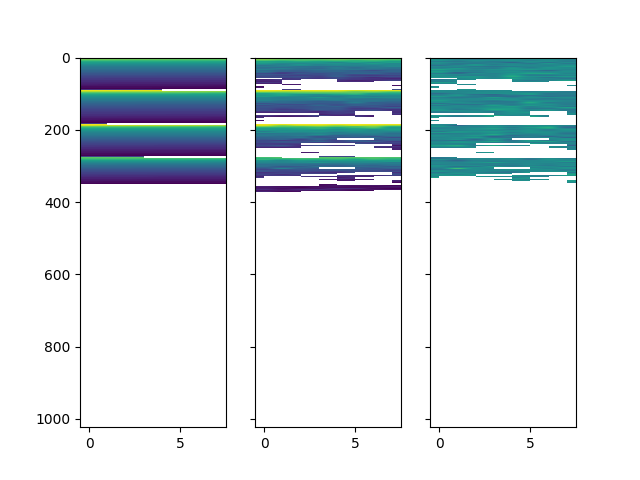

In [27]:
fig,ax = subplots(1,3, sharex=True, sharey=True)
ax[0].imshow(container1.nchan_array, aspect='auto')
ax[1].imshow(container2.nchan_array, aspect='auto')
ax[2].imshow(container2.nchan_array - container1.nchan_array, aspect='auto')

<IPython.core.display.Javascript object>


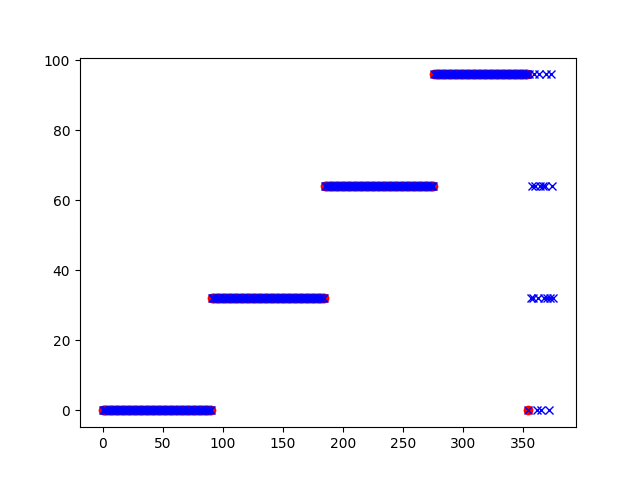

In [28]:
figure()
plot(container1.start_chan_array, 'ro')
plot(container2.start_chan_array,'bx')

In [29]:
container2.nchan
print(container2.nchan == sum(c.nchan for c in plan2.uvcells))

True


/var/folders/46/9g9nrj1x70d5nyxrqm1z6yb4009_fc/T/ipykernel_71567/290579682.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print(container2.nchan == sum(c.nchan for c in plan2.uvcells))


In [30]:
print(container1.nchan)
print(container1.nchan == sum(c.nchan for c in plan.uvcells))

29880
True


/var/folders/46/9g9nrj1x70d5nyxrqm1z6yb4009_fc/T/ipykernel_71567/2707148480.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print(container1.nchan == sum(c.nchan for c in plan.uvcells))


In [31]:
blid = 268.0
cells1 = container1.uvcells_of(blid)
cells2 = container2.uvcells_of(blid)

In [32]:
container2.plan.pipeline_plan.nbl

253

In [33]:
container2.total_overlap


27424

In [34]:
container2.nchan

29880

In [35]:
cells2

[Cell blid=268.0 chan=0-7 freq=959.99-966.99 uvpix=(27, 232) upper_idx=6073 uvpix_upper=(229, 24),
 Cell blid=268.0 chan=8-31 freq=967.99-990.99 uvpix=(28, 232) upper_idx=6072 uvpix_upper=(228, 24),
 Cell blid=268.0 chan=32-40 freq=991.99-999.99 uvpix=(28, 232) upper_idx=6072 uvpix_upper=(228, 24),
 Cell blid=268.0 chan=41-42 freq=1000.99-1001.99 uvpix=(28, 231) upper_idx=6303 uvpix_upper=(228, 25),
 Cell blid=268.0 chan=43-63 freq=1002.99-1022.99 uvpix=(29, 231) upper_idx=6302 uvpix_upper=(227, 25),
 Cell blid=268.0 chan=64-78 freq=1023.99-1037.99 uvpix=(29, 231) upper_idx=6302 uvpix_upper=(227, 25),
 Cell blid=268.0 chan=79-81 freq=1038.99-1040.99 uvpix=(30, 231) upper_idx=6301 uvpix_upper=(226, 25),
 Cell blid=268.0 chan=82-95 freq=1041.99-1054.99 uvpix=(30, 230) upper_idx=6531 uvpix_upper=(226, 26),
 Cell blid=268.0 chan=96-113 freq=1055.99-1072.99 uvpix=(30, 230) upper_idx=6531 uvpix_upper=(226, 26),
 Cell blid=268.0 chan=114-119 freq=1073.99-1078.99 uvpix=(31, 230) upper_idx=6530

OK - I'm not really thinking clearly here - I think I need to come back to this when I'm not sick. It's fine, it just takes a bit more wrangling to celar up the data structure.

In [47]:
plan1 = PipelinePlan(f, '--ndm 40')
plan2 = PipelinePlan(f2, '--ndm 40', prev_plan=plan1)

INFO:craft.craco_plan:Unknown beamid
INFO:craft.craco_plan:making Plan values=Namespace(uv='uv_data', pickle_fname='pipeline.pickle', npix=256, os='2.1,2.1', cell=None, nt=256, ndm=40, max_ndm=1024, max_nbl=630.0, nbox=8, boxcar_weight='sum', nuvwide=8, nuvmax=8192, ncin=32, ndout=186, threshold=3, fdmt_scale=1.0, fft_scale=10.0, show_image=False, show_fdmt=False, save=False, flag_ants=None, verbose=False, show=False, target_input_rms=512, calibration=None) prev plan:None
/Users/ban115/bolton/craft/craft-github/src/craft/uvfits.py:270: UserWarning: Dont yet support multiple source files: 2 - using source at 2 which is (2, 'SMARTIE_15', 0, '', 0.0, 0.0, 0.0, 0.0, 0.0, 120.0000000000014, 80.78620373454955, -35.89288784920107, 2000.0, 80.78620373454955, -35.89288784920107, 0.0, 0.0, 0.0, 0.0)
  warnings.warn(f'Dont yet support multiple source files: {len(source_table)} - using source at {first_targetidx} which is {row}')
INFO:craft.uvfits:Got radec=(80.78620373454955 deg/-35.8928878492010

parsing values --ndm 40
parsing values --ndm 40


/Users/ban115/bolton/craft/craft-github/src/craft/uvfits.py:270: UserWarning: Dont yet support multiple source files: 2 - using source at 2 which is (2, 'SMARTIE_15', 0, '', 0.0, 0.0, 0.0, 0.0, 0.0, 120.0000000000014, 80.78620373454955, -35.89288784920107, 2000.0, 80.78620373454955, -35.89288784920107, 0.0, 0.0, 0.0, 0.0)
  warnings.warn(f'Dont yet support multiple source files: {len(source_table)} - using source at {first_targetidx} which is {row}')
INFO:craft.uvfits:Got radec=(80.78620373454955 deg/-35.89288784920107 deg) from source table for SMARTIE_15
INFO:craft.craco_plan:Nbl=253 Fch1=959990740.740740 foff=1000000.000000 nchan=120 lambdamin=0.278038 uvmax=(5739.790748996851, 4236.413373224359) max baseline=(1.5958776657498672, 1.1778822226915506) resolution=[35.93594528 48.68854573]arcsec uvcell=[17.11235489 23.18502178] arcsec uvcell= (47.084220987864796, 34.751828452231074) lambda FoV=[1.21687857 1.64871266] deg oversampled=(2.1, 2.1) wcs=WCS Keywords

Number of WCS axes: 2
CTY

In [48]:
plan1.fdmt_plan

INFO:craft.fdmt_plan:Started with 2115 cells which would need at least 265 runs
INFO:craft.fdmt_plan:With 5 channels at [  0  32  64  96 128] we needed 354 runs. An increase of 1.336 
INFO:craft.fdmt_plan:Creating FdmtPlan for 2115 cells plan=<craft.craco_plan.PipelinePlan object at 0x1b46876a0> prev_plan=None We have 354 initial runs
INFO:craft.fdmt_plan:Found zero cell among runs: (90, 5)
INFO:craft.fdmt_plan:FDMT zero cell is (90, 5)=725
INFO:craft.fdmt_plan:FDMT plan has ntotal=2832 of 354 runs with packing efficiency 0.746822. Grid read requires efficiency of > 0.345703 of NUV=8192. History size square=155918592 minimal=8131744 =0 256MB HBM banks
INFO:craft.craco_plan:Saving uvgrid.split shape=(2816, 14) type=float64 to uv_data.uvgrid.split.txt header=ant1, ant2, u(pix), v(pix), chan1, chan2, irun, icell, total_overlap, max_idm, max_offset, offset_cff, idm_cff, fch1
INFO:craft.craco_plan:Got 1963 unique UV coords. Upper=True
INFO:craft.craco_plan:Need to write 123 groups of 16 reg

FdmtPlan ncell=2115 zero cell=(90, 5) nruns=354

In [49]:
plan2.fdmt_plan

INFO:craft.fdmt_plan:Started with 2116 cells which would need at least 265 runs
INFO:craft.fdmt_plan:With 5 channels at [  0  32  64  96 128] we needed 354 runs. An increase of 1.336 
INFO:craft.fdmt_plan:Creating FdmtPlan for 2116 cells plan=<craft.craco_plan.PipelinePlan object at 0x120517ca0> prev_plan=<craft.craco_plan.PipelinePlan object at 0x1b46876a0> We have 354 initial runs
INFO:craft.fdmt_plan:Migrate plan from FdmtPlan ncell=2115 zero cell=(90, 5) nruns=354 to FdmtPlan ncell=2116 zero cell=None nruns=0 with 354 new runs
INFO:craft.fdmt_plan:Migrated plan from FdmtPlanContainer nruns=354 nc=29880 overlap=0=0.0% to FdmtPlanContainer nruns=376 nc=29880 overlap=27424=91.8%
INFO:craft.fdmt_plan:Found zero cell among runs: (70, 2)
INFO:craft.fdmt_plan:FDMT zero cell is (70, 2)=562
INFO:craft.fdmt_plan:FDMT plan has ntotal=3008 of 376 runs with packing efficiency 0.703457. Grid read requires efficiency of > 0.367188 of NUV=8192. History size square=165608448 minimal=8634576 =0 256M

FdmtPlan ncell=2116 zero cell=(70, 2) nruns=376